# Covid-19 Polynomial Fitting

The aim of this notebook is to identify the optimal model from a given simple
parametric family that best characterizes the growth curve of COVID-19 cases without 
overfitting the data.  
The first part of the dataset (up to 20 March) will be used for training, along [Bayesian Information Criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion) for selecting the degree of our polynomial.  
The chosen model will be tested on the rest of the dataset.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import datetime

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

## Data gathering

As in the [previous notebook](https://github.com/MikeXydas/Weekend-EDAs/blob/master/Covid19_Testing_Importance.ipynb) the number of confirmed cases will be taken from the [John Hopkins](https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv) dataset which is daily updated.  
We will group by country name and sum over provinces/states so as to have the cases per country.

In [4]:
confirmed_cases_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv', 
                                 index_col=['Country/Region'])

# Drop unused columns Lat, Long
confirmed_cases_df = confirmed_cases_df.drop('Lat', axis=1)
confirmed_cases_df = confirmed_cases_df.drop('Long', axis=1)

# Group by and sum number of cases of each country
confirmed_cases_df = confirmed_cases_df.groupby(['Country/Region']).sum()

display(confirmed_cases_df)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,21,22,22,22,24,24,40,40,74,84
Albania,0,0,0,0,0,0,0,0,0,0,...,51,55,59,64,70,76,89,104,123,146
Algeria,0,0,0,0,0,0,0,0,0,0,...,54,60,74,87,90,139,201,230,264,302
Andorra,0,0,0,0,0,0,0,0,0,0,...,2,39,39,53,75,88,113,133,164,188
Angola,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,2,2,3,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,0,0,0,0,0,0,0,0,0,0,...,17,33,36,42,42,70,70,77,84,91
Vietnam,0,2,2,2,2,2,2,2,2,2,...,61,66,75,85,91,94,113,123,134,141
West Bank and Gaza,0,0,0,0,0,0,0,0,0,0,...,38,39,41,44,47,48,52,59,59,-1


We will try to forecast the global number of cases so we can sum the rows. However, we keep the `confirmed_cases_df` DataFrame in case we need it for comparisons.

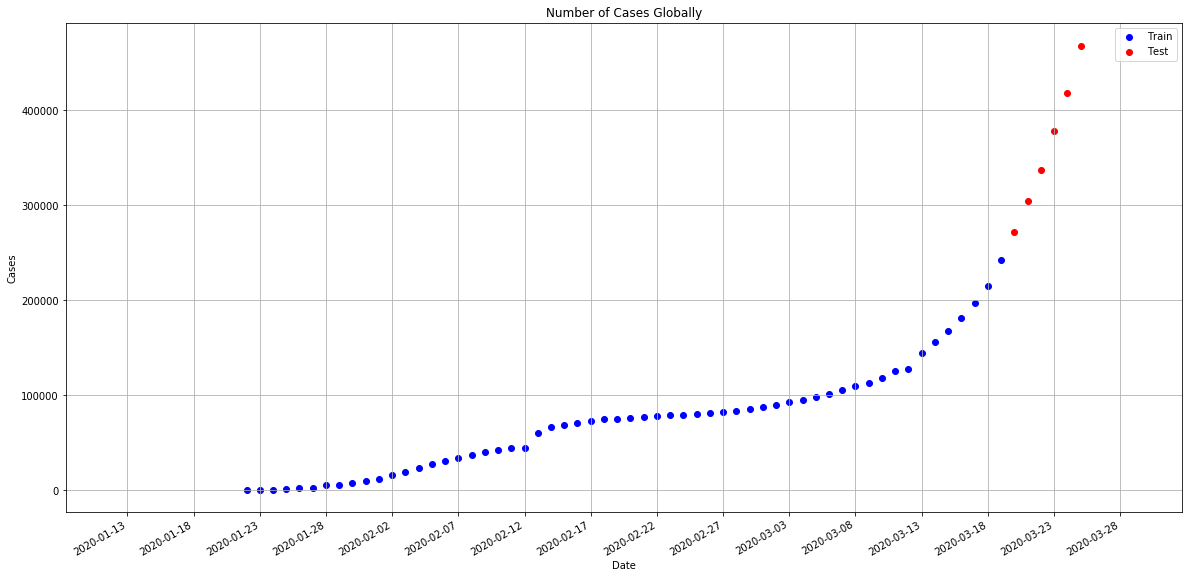

In [37]:
global_cases_df = confirmed_cases_df.sum()    # Sum over all countries to get global number of cases for each day

# Plot the number of cases for each day globally
x_values = [datetime.datetime.strptime(d[:-2]+ '20' + d[-2:],"%m/%d/%Y").date() for d in global_cases_df.index]
y_values = global_cases_df.values

fig, ax = plt.subplots(figsize=(20, 10))
ax = plt.gca()
formatter = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(formatter)

locator = mdates.DayLocator(interval=5)    # Add an interval on the x-axis so as to not be cluttered
ax.xaxis.set_major_locator(locator)

# We will use the last 6 days as a test set
plt.scatter(x_values[:-6], y_values[:-6], color="blue", label="Train")
plt.scatter(x_values[-6:], y_values[-6:], color="red", label="Test")

ax.set_xlabel("Date")
ax.set_ylabel("Cases")
plt.title("Number of Cases Globally")
plt.legend()

plt.grid()
plt.gcf().autofmt_xdate()
plt.show()

## Polynomial Regression

On the above plot we will use the blue part in order to find the degree of our polynomial and the red part for testing our model. (The small gap between the lines is a graphical error, no values are missing and the line should be considered continuous).

### Training

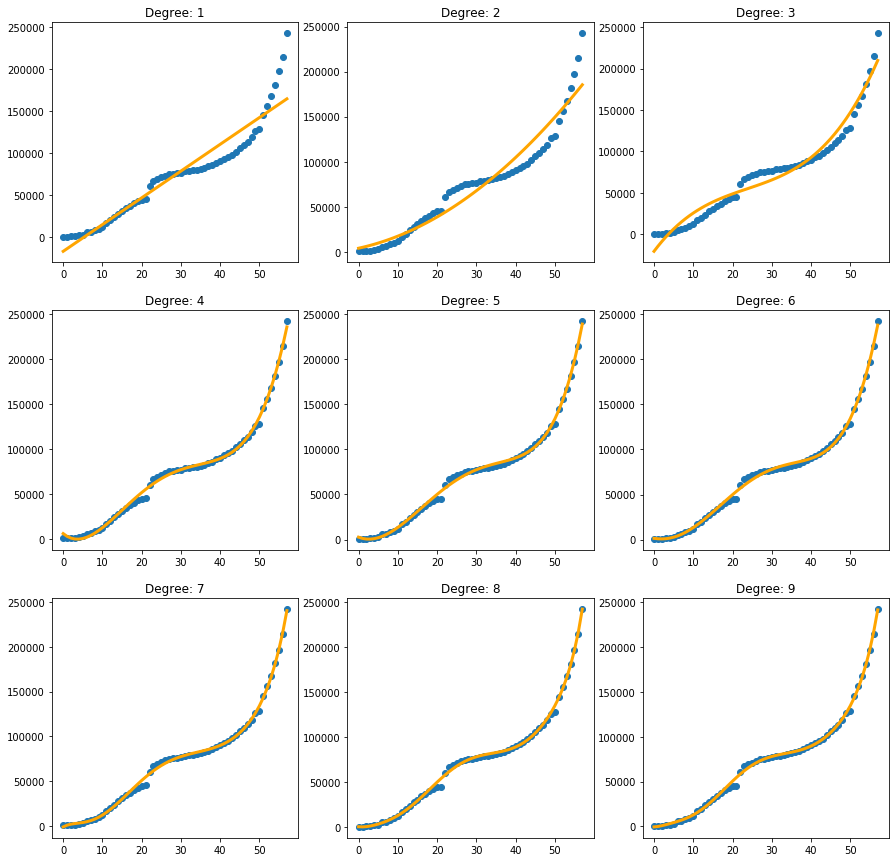

In [57]:
x_series = np.arange(len(x_values))    # Transform dates to an integer mapping for easier parsing

# Split the data in training and testing and
# add a new axis so as the PolynomialFeatures input has the expected 2D shape
train_X = x_series[:-6, np.newaxis]
train_Y = y_values[:-6, np.newaxis]

test_X = x_series[-6:, np.newaxis]
test_Y = y_values[-6:, np.newaxis]

 
fig = plt.figure(figsize=(15, 15))
plot_index = 1

# We will create 9 plots one for each degree
for degree in range(1,10):
    ax = fig.add_subplot(3, 3, plot_index)
    
    # Plot our true data
    plt.scatter(train_X, train_Y)
    
    # Create the new features
    # eg degree=2, [a] => [a^0, a^1, a^2]
    polynomial_features = PolynomialFeatures(degree=degree)
    x_poly = polynomial_features.fit_transform(train_X)

    # Train a linear regression model with our new polynmial feature set
    model = LinearRegression()
    model.fit(x_poly, train_Y)
    y_poly_pred = model.predict(x_poly)    # Use our new model to predict on our train set
    
    plt.plot(train_X, y_poly_pred, linewidth=3, label=f'Degree: {str(degree)}', color="orange")
    plot_index += 1
    
    plt.title(f"Degree: {degree}")
    
    
plt.show()

Visually we observe that the polynomial of the 4th degree is the simplest model that seems to be good at capturing the shape of our data. To prove this with a more robust way we will use the Bayesian Information Criterion (BCI). 